Author: Vijul Shah<br/>
Contact E-mail: shahv@rhrk.uni-kl.de<br/>
Project: ML & DL methods on Earth Observation data and applications<br/>
Dataset Used: Nasa Marine Debris<br/>

Importing Necessary Libraries

In [1]:
import os
import json
import re
from glob import glob
import tarfile
from dateutil.parser import parse

from pathlib import Path
from radiant_mlhub import Dataset, Collection, client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import asarray

import copy
import torch
from torch import nn, optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

import shap

import requests
from PIL import Image
from io import BytesIO

c:\Users\VIJUL\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Saving API Key from RadianMLHub Profile

In [3]:
os.environ['MLHUB_API_KEY'] = '8d8dbdc600cc30921997e84958917fca835349a61e3ece54b671d7a5bc4e3693'

Adding Tensor tranformation definations to convert image into tensors or any arrays into tensors

In [4]:
transform_to_tensor = transforms.Compose([transforms.ToTensor()])
transform_pil_to_tensor = transforms.Compose([transforms.PILToTensor()])

### Fetching Dataset<br/>
- Fetching the dataset from the library using the dataset-id name.
- Filtering the dataset to fetch data between specified time range. Here we are reducing the temporal range so that we get sufficient data to train the model faster.

In [5]:
datasetname = 'nasa_marine_debris'

In [104]:
dataset = Dataset.fetch_by_id(datasetname)
my_start_date=parse("2018-04-01T00:00:00+0000")
my_end_date=parse("2019-05-01T00:00:00+0000")
dataset.download('./data/',datetime=(my_start_date, my_end_date))

print('Source Imagery Collections\n--------------------------')
for collection in dataset.collections.source_imagery:
    print(collection.id)

print('')

print('Label Collections\n-----------------')
for collection in dataset.collections.labels:
    print(collection.id)

unarchive nasa_marine_debris.tar.gz: 100%|██████████| 2830/2830 [00:00<00:00, 6897.89it/s]
filter by temporal query: 12499it [00:00, 29934.70it/s]           
download assets: 100%|██████████| 757/757 [00:08<00:00, 89.33it/s] 

Source Imagery Collections
--------------------------
nasa_marine_debris_source

Label Collections
-----------------
nasa_marine_debris_labels


Seeing the summary of the dataset fetched

In [105]:
def print_summary(item, collection):
    print(f'Collection: {collection.id}')
    print(f'Item: {item["id"]}')
    print('Assets:')
    for asset_name, asset in item.get('assets', {}).items():
        print(f'- {asset_name}: {asset["href"]} {asset["type"]}')
    
    print('\n')

for collection in dataset.collections:
    item = next(client.list_collection_items(collection.id, limit=1))
    print_summary(item, collection)

Collection: nasa_marine_debris_source
Item: nasa_marine_debris_source_20190418_074358_0f3c_37604-25021-16
Assets:
- image_jpeg: https://api.radiant.earth/mlhub/v1/download/gAAAAABjXn_A3_crDChMosHdOr2HoyN_wicmjqBiHPJe9M4fObTawwHjsuwOBA4YFqKfOOX6Bsi7MXQht75fcJS-pGTXf953QaTRgRXffo-jIoWt60CkPc63rQXjl4YXnd0qinHAlvGLIXq2aqoqjpqlfrf9S1PK38e_pfkQWMF1l4ZbrLOZXxO4J9bK3aDkqKcw43bTVRIbYEIXgDW-m4ewV20gXaGvEAC3viBf_nJt7_25NYV5QJU4SUrQFSod74s8N-xIBGQ5ri0Rb8v2Htju4XSK7ux5DVaYj7tpiOeRk4Zc-N8bOIyZvP-21jOnG_Vf09fxF9zP image/jpeg
- image_geotiff: https://api.radiant.earth/mlhub/v1/download/gAAAAABjXn_A7RB_CujeYJW_DysdXZnyL0zNvwMs3IeVywRa8L_mBKVfFBHAtg9y2h_7p64Ogu9DySW-pcTOte6-tfb4hhXjpGshw5-mFl3kiuSjKCzPI0CSfwuM2L-rbUaeNauACzm_BJfSuJOO-Mmo380ssK0VMZLNzCIfR6GYiGOxeGe4XI8H0K0JUn3CL2TtAU008XsdkG8VKUEAH7EhmUusczRvVh9NpE1jDkc2zcKHfoDIy_9y3Y7grAEtxv1ro-LjLjJvLZ_yDgZt0tZeDTaWoHjNBe58odXZ8D2qMkjmqHCAM90g1dOsCgQdRL8BBYmCNvQL image/tiff; application=geotiff


Collection: nasa_marine_debris_labels
Item: nasa_marine_

### Loading Data into a Dataframe

In [6]:
train_source = 'nasa_marine_debris_source'
train_labels = 'nasa_marine_debris_labels'

Training Data

In [7]:
download_dir = Path('./data').resolve()
train_data = []
jpg_names = glob(str(download_dir / datasetname / train_source / '**' / '*.jpg'))

for jpg_path in jpg_names:
    jpg_path = Path(jpg_path)

    # Get the IDs and file paths
    labels_path = "./data/nasa_marine_debris/nasa_marine_debris_labels/" + jpg_path.parent.stem.replace('source','labels') +"/pixel_bounds.npy"
    
    image_id = '_'.join(jpg_path.parent.stem.rsplit('_', 3)[1:])
    
    pixels_bound = np.load(labels_path).tolist()
    
    img = Image.open(jpg_path)
    img = transform_pil_to_tensor(img)

    for box in pixels_bound:
        train_data.append([
            image_id,
            img,
            box[4],
            box[0],
            box[1],
            box[2],
            box[3]
        ])

df = pd.DataFrame(
    np.array(train_data),
    columns=['img_id', 'image', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax']
).sort_values(by=['img_id']).reset_index(drop=True)

df.to_numpy()
df.head()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


,img_id,image,class_id,xmin,ymin,xmax,ymax
0,074358_0f3c_37604-25021-16,"[[[tensor(199, dtype=torch.uint8), tensor(202,...",1,159,145,187,177
1,074358_0f3c_37604-25021-16,"[[[tensor(199, dtype=torch.uint8), tensor(202,...",1,42,16,74,48
2,075902_103e_39052-26411-16,"[[[tensor(38, dtype=torch.uint8), tensor(41, d...",1,117,71,147,96
3,075902_103e_39052-26411-16,"[[[tensor(38, dtype=torch.uint8), tensor(41, d...",1,121,56,140,78
4,075902_103e_39053-26412-16,"[[[tensor(40, dtype=torch.uint8), tensor(41, d...",1,128,0,163,15


### Visualizing the bounding box on debris

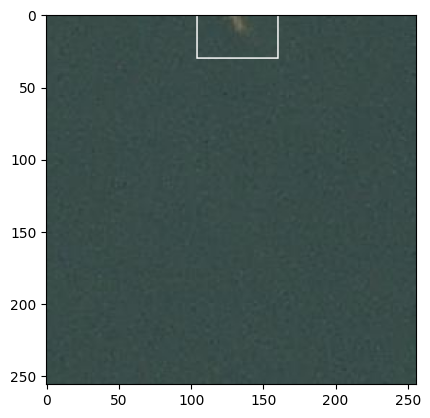

In [8]:
sample_data = df.iloc[np.random.randint(0,len(df))]
bbox = torch.tensor([sample_data["xmin"], sample_data["ymin"], sample_data["xmax"], sample_data["ymax"]], dtype=torch.float)
bbox = bbox.unsqueeze(0)
img = sample_data['image']
img = draw_bounding_boxes(img, bbox, width=1, colors=(255,255,255))
img = torchvision.transforms.ToPILImage()(img)
plt.imshow(img)
plt.show()

Splitting original data into testing and training data

In [9]:
from sklearn.model_selection import train_test_split
bboxes = []
images = []
labels = []
for d in range(len(df)):
    bboxes.append([df.iloc[d]["xmin"], df.iloc[d]["ymin"], df.iloc[d]["xmax"], df.iloc[d]["ymax"]])
    images.append(df.iloc[d]["image"].numpy())
    labels.append(df.iloc[d]["class_id"])
images = np.array(images)
bboxes = np.array(bboxes)
labels = np.array(labels)
train_images, val_images, train_labels, val_labels, train_boxes, val_boxes= train_test_split(images, labels, bboxes, test_size=0.2, random_state=42)

In [10]:
class CustomDataset():
    def __init__(self, train_images, train_labels, train_boxes):
        self.images = torch.Tensor(train_images).float()
        self.labels = torch.from_numpy(train_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(train_boxes).float()

    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        return (self.images[idx],
              self.labels[idx],
              self.boxes[idx])

In [11]:
class ValDataset(CustomDataset):

    def __init__(self, val_images, val_labels, val_boxes):

        self.images = torch.Tensor(val_images).float()
        self.labels = torch.from_numpy(val_labels).type(torch.LongTensor)
        self.boxes = torch.from_numpy(val_boxes).float()

In [12]:
dataset = CustomDataset(train_images, train_labels, train_boxes)
valdataset = ValDataset(val_images, val_labels, val_boxes)

In [13]:
batch_size = 32

In [14]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
valdataloader = torch.utils.data.DataLoader(valdataset, batch_size=batch_size, shuffle=True)

### Creating the Deep learning Model

In [15]:
import torchvision.models as models
import torch.nn.functional as F

class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [16]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [17]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.float()
        y_class = y_class
        y_bb = y_bb.float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [19]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    train_loss_array = []
    validation_accuracies = []
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.float()
            y_class = y_class
            y_bb = y_bb.float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        train_loss_array.append(train_loss)
        val_loss, val_acc = val_metrics(model, valdataloader, C)
        validation_accuracies.append(val_acc)
        print("Epoch:",i," -> train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    plt.plot(train_loss_array)
    plt.plot(validation_accuracies)
    return model

In [20]:
model = BB_model()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.


Training the model

In [120]:
trained_model = train_epocs(model, optimizer, dataloader, valdataloader, epochs=3)

Epoch: 0  -> train_loss 1.152 val_loss 2.062 val_acc 0.921
Epoch: 1  -> train_loss 0.360 val_loss 0.303 val_acc 1.000
Epoch: 2  -> train_loss 0.290 val_loss 0.303 val_acc 1.000


In [121]:
torch.save(trained_model, "Marine_Debris_Prediction_Model")

### Testing New Image On Trained Model

In [21]:
marine_debris_model = torch.load("Marine_Debris_Prediction_Model")

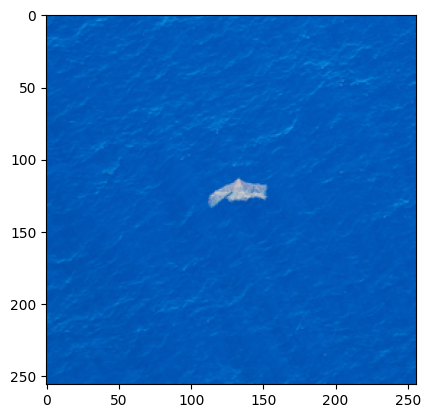

In [22]:
path = 'http://assets.iflscience.com/assets/articleNo/38282/iImg/40045/1475664999-toc-ae-29.jpg'
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f)
    img = img.resize((256, 256))
x = (np.expand_dims(np.array(img), -1))/255.
plt.imshow(x.squeeze(-1))

In [23]:
path = 'http://assets.iflscience.com/assets/articleNo/38282/iImg/40045/1475664999-toc-ae-29.jpg'
r = requests.get(path)
test_image = None
predicted_result = None
with BytesIO(r.content) as f:
    img = Image.open(f)
    img = img.resize((256, 256))
    img = transform_pil_to_tensor(img)
    test_image = img
    img = img.float()
    img = torch.FloatTensor(img[None,])
    predicted_result = marine_debris_model(img)
predicted_result

(tensor([[-2.4498,  5.8389, -3.0141, -3.2522]], grad_fn=<AddmmBackward0>),
 tensor([[ 83.2925,  91.5311, 170.8725, 176.8014]], grad_fn=<AddmmBackward0>))

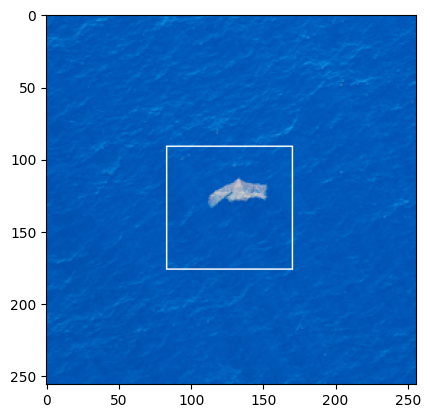

In [24]:
test_bbox = predicted_result[1][0]
test_bbox = test_bbox.unsqueeze(0)
test_bbox_img = draw_bounding_boxes(test_image, test_bbox, width=1, colors=(255,255,255))
test_bbox_img = torchvision.transforms.ToPILImage()(test_bbox_img)
plt.imshow(test_bbox_img)
plt.show()

### Adding SHAP to use XAI

In [27]:
# select a set of background examples to take an expectation over
background = train_images[np.random.choice(train_images.shape[0], 100, replace=False)]
# background = train_images

# explain predictions of the model on four images
e = shap.DeepExplainer(marine_debris_model, torch.FloatTensor(background))
# e = shap.DeepExplainer(marine_debris_model, background)
shap_values = e.shap_values(val_images[1:20])

# plot the feature attributions
shap.image_plot(shap_values, -val_images[1:20])

AttributeError: 'tuple' object has no attribute 'device'